## Install hail

In [ ]:
%%bash
# install hail in a conda env.
#conda create -n hail python'>=3.6,<3.8'
#conda activate hail
#pip install hail


In [47]:
# let's also install rpy2 for R
#conda install -c r rpy2

## Setup

In [1]:
import hail as hl
hl.init(default_reference='GRCh37')

from hail.plot import show, output_notebook
from pprint import pprint
hl.plot.output_notebook()

Running on Apache Spark version 2.4.1
SparkUI available at http://da02:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.39-ef87446bd1c7
LOGGING: writing to /PHShome/bm363/WES_analysis/notebooks_codes/hail-20200606-2125-0.2.39-ef87446bd1c7.log


Loading BokehJS ...

In [2]:
# let's change the working directory to where the final vcf files are saved
import os
os.chdir("/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf")

In [1]:
# for running some R codes as well
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)

/PHShome/bm363/.conda/envs/hail/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

  warnings.warn(x, RRuntimeWarning)
/PHShome/bm363/.conda/envs/hail/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ✔ ggplot2 3.2.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0

  warnings.warn(x, RRuntimeWarning)
/PHShome/bm363/.conda/envs/hail/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)


## Load genotype data

In [3]:
# convert the vcf file to Hail MatrixTable format
# (the following line is run run only once)

#hl.import_vcf('/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/SysBio_indels_recalibrated_b37.vcf',reference_genome='GRCh37').write('/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/SysBio_indels_recalibrated_b37.mt', overwrite=True)


2020-06-03 10:41:38 Hail: INFO: Coerced sorted dataset
2020-06-03 10:41:49 Hail: INFO: wrote matrix table with 374446 rows and 232 columns in 74 partitions to /data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/SysBio_indels_recalibrated_b37.mt


Let's load the VCF data and convert it to Hail MatrixTable format (Hail's native file format for faster processing).

In [3]:
# now let's read this file
mt = hl.read_matrix_table('/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/SysBio_indels_recalibrated_b37.mt')


In [4]:
# filter variants to only those with PASS entry in the filters column
mt_pass = mt.filter_rows(hl.len(mt.filters) == 0)
# number of variants and samples
print('%d variants, %d samples' % mt_pass.count())

264756 variants, 232 samples


Note that this field is computed with GATK's ApplyVQSR tool. It produces filter criteria with multiple thresholds.

In [7]:
%%bash
cd /data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf
grep -v '#' SysBio_indels_recalibrated_b37.vcf | cut -f7 | sort | uniq -c

 264756 PASS
   3636 VQSRTrancheINDEL90.00to99.00
   6294 VQSRTrancheINDEL99.00to99.90
    946 VQSRTrancheINDEL99.90to100.00
  28183 VQSRTrancheSNP90.00to99.00
  50844 VQSRTrancheSNP99.00to99.90
  19787 VQSRTrancheSNP99.90to100.00


In [5]:
# let's export this as vcf file (may be needed for other tools)
hl.export_vcf(mt_pass, '/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/SysBio_indels_recalibrated_b37_pass.vcf.bgz')

2020-06-03 21:20:39 Hail: INFO: merging 74 files totalling 272.7M...
2020-06-03 21:20:41 Hail: INFO: while writing:
    /data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/SysBio_indels_recalibrated_b37_pass.vcf.bgz
  merge time: 1.795s


## Exploring variants

In [6]:
mt_pass.describe(widget=False)

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh37>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DB: bool, 
        DP: int32, 
        DS: bool, 
        END: int32, 
        ExcessHet: float64, 
        FS: float64, 
        HaplotypeScore: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQRankSum: float64, 
        NEGATIVE_TRAIN_SITE: bool, 
        POSITIVE_TRAIN_SITE: bool, 
        QD: float64, 
        RAW_MQ: float64, 
        ReadPosRankSum: float64, 
        ReverseComplementedAlleles: bool, 
        SOR: float64, 
    

- ### Summary of variant counts

In [7]:
hl.summarize_variants(mt_pass)

Number of alleles,Count
2,260567
3,2729
4,762
5,357
6,192
7,149
Allele type,Count
SNP,250500
Deletion,12604
Insertion,8185


- ### filter out multi-allelic variants

In [8]:
# number of multi-alletic variants
mt_pass.filter_rows(hl.len(mt_pass.alleles)>2).count_rows()

4189

In [5]:
mt_pass = mt_pass.filter_rows(hl.len(mt_pass.alleles)==2)

# note that we could instead just split multiallelic variants 
#mt_pass = hl.split_multi_hts(mt_pass)

In [10]:
# counts of individual variants
snv_counts = mt_pass.aggregate_rows(
    hl.array(
        hl.agg.filter(
            hl.is_snp(mt_pass.alleles[0],mt_pass.alleles[1]),
            hl.agg.counter(mt_pass.alleles))))
sorted(snv_counts,
      key=lambda x: -x[1])

[(['G', 'A'], 64749),
 (['C', 'T'], 64551),
 (['A', 'G'], 27661),
 (['T', 'C'], 27603),
 (['C', 'G'], 11598),
 (['G', 'C'], 11403),
 (['C', 'A'], 9849),
 (['G', 'T'], 9748),
 (['T', 'G'], 5991),
 (['A', 'C'], 5917),
 (['T', 'A'], 4575),
 (['A', 'T'], 4544)]

- ### Quality metrics of variants

The most relevant (for QC) variables includes:
- DP: read depth (coverage) of a site
- GQ: genotype quality
- QD: QUAL/(depth of non-reference reads)
- MQ: mapping quality of reads


In [11]:
mt_pass.DP.summarize()

Non-missing,60451525 (100.00%)
Missing,19 (0.00%)
Minimum,0
Maximum,1118
Mean,39.06
Std Dev,21.38


In [13]:
p = hl.plot.histogram(mt_pass.DP, range=(0,200), bins=200, title='DP Histogram', legend='DP')
show(p)

In [14]:
mt_pass.GQ.summarize()

Non-missing,60414859 (99.94%)
Missing,36685 (0.06%)
Minimum,0
Maximum,99
Mean,89.94
Std Dev,20.24


In [15]:
p = hl.plot.histogram(mt_pass.GQ, range=(0,100), bins=100, title='GQ Histogram', legend='GQ')
show(p)

In [16]:
p = hl.plot.histogram(mt_pass.info.MQ, range=(0,65), bins=65, title='MQ Histogram', legend='MQ')
show(p)

In [17]:
p = hl.plot.histogram(mt_pass.info.QD, range=(0,40), bins=40, title='QD Histogram', legend='QD')
show(p)

In [6]:
# let's run the generic variable qc to compute variable QC stats
mt_pass = hl.variant_qc(mt_pass)

In [19]:
mt_pass.variant_qc.show()

locus,alleles,variant_qc.dp_stats.mean,variant_qc.dp_stats.stdev,variant_qc.dp_stats.min,variant_qc.dp_stats.max,variant_qc.gq_stats.mean,variant_qc.gq_stats.stdev,variant_qc.gq_stats.min,variant_qc.gq_stats.max,variant_qc.AC,variant_qc.AF,variant_qc.AN,variant_qc.homozygote_count,variant_qc.call_rate,variant_qc.n_called,variant_qc.n_not_called,variant_qc.n_filtered,variant_qc.n_het,variant_qc.n_non_ref,variant_qc.het_freq_hwe,variant_qc.p_value_hwe
locus<GRCh37>,array<str>,float64,float64,float64,float64,float64,float64,float64,float64,array<int32>,array<float64>,int32,array<int32>,float64,int64,int64,int64,int64,int64,float64,float64
1:865584,"[""G"",""A""]",3.22e+01,6.23e+00,1.10e+01,4.90e+01,8.66e+01,1.61e+01,3.00e+01,9.90e+01,"[461,3]","[9.94e-01,6.47e-03]",464,"[229,0]",1.00e+00,232,0,0,3,3,1.29e-02,5.03e-01
1:865628,"[""G"",""A""]",3.68e+01,3.49e+00,2.40e+01,5.80e+01,9.83e+01,4.35e+00,6.60e+01,9.90e+01,"[461,3]","[9.94e-01,6.47e-03]",464,"[229,0]",1.00e+00,232,0,0,3,3,1.29e-02,5.03e-01
1:865694,"[""C"",""T""]",3.30e+01,6.46e+00,1.20e+01,4.60e+01,8.48e+01,1.73e+01,3.00e+01,9.90e+01,"[444,20]","[9.57e-01,4.31e-02]",464,"[212,0]",1.00e+00,232,0,0,20,20,8.27e-02,6.74e-01
1:865705,"[""C"",""T""]",3.03e+01,6.95e+00,1.00e+01,4.90e+01,7.90e+01,1.85e+01,6.00e+00,9.90e+01,"[463,1]","[9.98e-01,2.16e-03]",464,"[231,0]",1.00e+00,232,0,0,1,1,4.31e-03,5.00e-01
1:866422,"[""C"",""T""]",3.77e+01,6.28e+00,2.20e+01,9.20e+01,9.81e+01,5.38e+00,5.20e+01,9.90e+01,"[460,4]","[9.91e-01,8.62e-03]",464,"[228,0]",1.00e+00,232,0,0,4,4,1.71e-02,5.06e-01
1:871173,"[""C"",""T""]",3.33e+01,6.33e+00,1.00e+01,4.90e+01,8.95e+01,1.56e+01,2.20e+01,9.90e+01,"[463,1]","[9.98e-01,2.16e-03]",464,"[231,0]",1.00e+00,232,0,0,1,1,4.31e-03,5.00e-01
1:871215,"[""C"",""G""]",3.85e+01,7.97e+00,1.30e+01,9.40e+01,9.80e+01,5.78e+00,3.60e+01,9.90e+01,"[444,20]","[9.57e-01,4.31e-02]",464,"[212,0]",1.00e+00,232,0,0,20,20,8.27e-02,6.74e-01
1:871239,"[""C"",""T""]",3.70e+01,4.31e+00,1.00e+01,5.00e+01,9.67e+01,8.52e+00,3.00e+01,9.90e+01,"[463,1]","[9.98e-01,2.16e-03]",464,"[231,0]",1.00e+00,232,0,0,1,1,4.31e-03,5.00e-01
1:874483,"[""A"",""C""]",3.73e+01,3.68e+00,3.30e+01,6.40e+01,9.90e+01,0.00e+00,9.90e+01,9.90e+01,"[463,1]","[9.98e-01,2.16e-03]",464,"[231,0]",1.00e+00,232,0,0,1,1,4.31e-03,5.00e-01


### Load pheno data

In [8]:
# let's import pheno data and incorporate it with the MatrixTable data
pheno1 = hl.import_table('/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/SB_pheno1.txt',
                        impute=True,
                        key='sid')

2020-06-06 21:27:04 Hail: INFO: Reading table to impute column types
2020-06-06 21:27:04 Hail: INFO: Loading 177 fields. Counts by type:
  92 fields: imputed int32
  45 fields: imputed float64
  31 fields: imputed str
  9 fields: str (no non-missing values for imputation)


In [7]:
# now incorporate it to the genotype data
mt_pass = mt_pass.annotate_cols(pheno = pheno1[mt_pass.s])

NameError: name 'pheno1' is not defined

In [23]:
mt_pass.aggregate_cols(hl.agg.counter(mt_pass.pheno.PTSD_status))

{'Negative': 117, 'Positive': 112, None: 3}

In [24]:
pprint(mt_pass.aggregate_cols(hl.agg.stats(mt_pass.pheno.CAPSTOT_cur)))

{'max': 113.0,
 'mean': 35.956331877729255,
 'min': 0.0,
 'n': 229,
 'stdev': 34.876172927562784,
 'sum': 8234.0}


In [25]:
pheno1.show()

ID,sid,CAPSB_LT,CAPSC_LT,CAPSD_LT,CAPS_2clusters_LT,CAPS_3clusters_LT,CAPSB_cur,CAPSC_cur,CAPSD_cur,CAPSTOT_cur,CAPS_2clusters_cur,CAPS_3clusters_cur,PTSD_status,sumETI_Gen_Trauma,sumETI_Phy_Abuse,sumETI_Emo_abuse,sumETI_Sex_Abuse,ETISR_Total,MCS,mcslite,BDI_total,BDI_cut18,PCLB,PCLC,PCLD,PCLCLUST,PCLSCORE,PCLDIAG,sclsom,SCLOC,SCLINT,SCLDEP,SCLANX,SCLHOS,SCLPHOB,SCLPAR,SCLPSY,SCLGSI,SCLPST,SCLPSDI,PTSD_duration,PDEQRV,PDEQEV,AUDIT,pdirv,pdiev,SASSR,SASWKSCH,SASSOCLS,SASEXFAM,SASMAR,SASPARNT,SASFAMUN,PSS,PANAS_PA,PANAS_NA,PSQI,meanERS,sumERS,STAXI1,ASI,AGG_PHYS,AGG_MENT,PF_T,RP_T,BP_T,GH_T,VT_T,RE_T,SF_T,MH_T,LES6pos,LES6neg,LES12pos,LES12neg,LES12TOT,LES6TOT,DRRI_D_score,DRRI_E_score,DRRI_J_score,DRRI_K2_score,DRRI_L_score,DRRI_M_score,sos,CAPSTOT_LT,STAXI2,emotional_abuse_score,physical_abuse_score,sexual_abuse_score,emontional_neglect_score,physical_neglect_score,DES_score,HIT6_score,PTCI_score,TimeP.x,Date.x,DemoAge,DemoGend,DemoOccupation,DemoEdu,DemoEth,DemoEth_Hispanic,DemoEth_Not_Hisp,DemoEth_Asian,DemoEth_Black,DemoEth_White,DemoEth_NativeAm,DemoEth_Other,DemoRel,DemoRel_Married,DemoRel_Living,DemoRel_SteadyRel,DemoRel_Divorced,DemoRel_Widow,DemoRel_Single,DemoChi,DemoChi2,DemoChi3,DemoMilBranch,Army,Navy,AirForce,Marine,NatGuard,Reserve,DemoMilServiceTours,DemoMilService_Iraq,DemoMilServiceIraqFrom_1,DemoMilServiceIraqTo_1,DemoMilServiceIraqMOS_1,DemoMilServiceIraqFrom_2,DemoMilServiceIraqTo_2,DemoMilServiceIraqMOS_2,DemoMilServiceIraqFrom_3,DemoMilServiceIraqTo_3,DemoMilServiceIraqMOS_3,DemoMilService_Afgh,DemoMilServiceAfghFrom_1,DemoMilServiceAfghTo_1,DemoMilServiceAfghMOS_1,DemoMilServiceAfghFrom_2,DemoMilServiceAfghTo_2,DemoMilServiceAfghMOS_2,DemoMilServiceAfghFrom_3,DemoMilServiceAfghTo_3,DemoMilServiceAfghMOS_3,DemoMilService_Other,DemoMilServiceOtherTours,DemoLocationOtherSpecify,DemoMilServiceOtherFrom_1,DemoMilServiceOtherTo_1,DemoMilServiceOtherMOS_1,DemoMilServiceOtherFrom_2,DemoMilServiceOtherTo_2,DemoMilServiceOtherMOS_2,DemoMilServiceOtherFrom_3,DemoMilServiceOtherTo_3,DemoMilServiceOtherMOS_3,DemoMilServiceLocation_Iraq,DemoMilServiceIraqTours,DemoMilServiceLocation_Afgh,DemoMilServiceAfghanistanTours,DemoMilServiceLocation_Other,Eth_race,TimeP.y,Date.y,Body_Weight,BMI,Standing_Height,Waist_Circumference,Hip_Circumference,Waist_to_Hip_Ratio,Systolic_Blood_Pressure,Diastolic_Blood_Pressure,Pulse,ABM3C
int32,str,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,str,int32,int32,int32,int32,int32,int32,float64,int32,int32,int32,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,str,int32,int32,str,int32,str,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,str,int32,int32,int32,int32,int32,int32,int32,int32,str,str,str,str,str,str,str,str,str,int32,str,str,str,str,str,str,str,str,str,int32,int32,str,str,str,str,str,str,str,str,str,str,str,int32,str,str,str,str,int32,str,float64,float64,int32,float64,float64,float64,int32,int32,int32,float64
201008,"""201008_S4""",2,10,7,0,0,0,0,0,0,0,0,"""Negative""",0,1,0,0,1,66,6.08e+01,2,0,1,0,0,1,28,0,8.30e-02,1.00e-01,6.67e-01,3.08e-01,2.00e-01,8.33e-01,2.86e-01,3.33e-01,3.00e-01,3.22e-01,20,1.45e+00,4.00e+00,1.20e+00,2.10e+00,3,1.92e+00,2.46e+00,1.77e+00,1.60e+00,2.22e+00,1.38e+00,1.89e+00,NA,1.50e+00,1.70e+00,40,15,6.00e+00,3.30e+00,33,15,7.00e+00,5.51e+01,5.72e+01,5.65e+01,5.72e+01,5.74e+01,5.12e+01,5.78e+01,5.61e+01,5.66e+01,5.84e+01,3,0,11,3,14,3,24,32,57,0,37,3,4.50e+00,19,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,"""20-Apr-11""",29,1,"""US ARMY""",4,NA,0,NA,

In [9]:
# now run the generic Hail's sample qc to compute sample QC stats
mt_pass = hl.sample_qc(mt_pass)

In [14]:
p = hl.plot.scatter(x=mt_pass.sample_qc.dp_stats.mean,
                    y=mt_pass.sample_qc.call_rate,
                    xlabel='Mean DP',
                    ylabel='Call Rate',
                    hover_fields={'ID': mt_pass.s},
                    size=8)
show(p)

## Filtering variants with QC criteria

In [22]:
filter_exp1 = (mt_pass.variant_qc.dp_stats.mean>10) & (mt_pass.info.MQ>40) & (mt_pass.info.QD >2) & (mt_pass.variant_qc.gq_stats.mean>20)

mt_filtered = mt_pass.filter_rows(filter_exp1)

f"Number of remaining variants: {mt_filtered.count_rows()}"


'Number of remaining variants: 255648'

In [16]:
print('Common variants: %d' % mt_filtered.filter_rows(mt_filtered.variant_qc.AF[1] >= 0.01).count_rows() )
print('Rare variants: %d' % mt_filtered.filter_rows(mt_filtered.variant_qc.AF[1] < 0.01).count_rows() )

Common variants: 106889
Rare variants: 148759


In [23]:
# let's rerun the QC computations
mt_filtered = hl.variant_qc(mt_filtered)
mt_filtered = hl.sample_qc(mt_filtered)

In [18]:
p = hl.plot.scatter(x=mt_filtered.sample_qc.dp_stats.mean,
                    y=mt_filtered.sample_qc.call_rate,
                    xlabel='Mean DP',
                    ylabel='Call Rate',
                    hover_fields={'ID': mt_filtered.s},
                    size=8)
show(p)

In [41]:
# let's export this as vcf file (may be needed for other tools)
hl.export_vcf(mt_filtered, '/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/SysBio_indels_recalibrated_b37_filtered.vcf.bgz')


2020-06-03 11:08:55 Hail: WARN: export_vcf: ignored the following fields:
    'pheno' (column)
    'sample_qc' (column)
    'variant_qc' (row)
2020-06-03 11:09:02 Hail: INFO: merging 74 files totalling 251.3M...
2020-06-03 11:09:03 Hail: INFO: while writing:
    /data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/SysBio_indels_recalibrated_b37_filtered.vcf.bgz
  merge time: 1.524s


In [12]:
# let's split it into common and rare variants
mt_commonVariants = mt_filtered.filter_rows(mt_filtered.variant_qc.AF[1] >= 0.01)
mt_rareVariants = mt_filtered.filter_rows(mt_filtered.variant_qc.AF[1] < 0.01)

In [20]:
hl.summarize_variants(mt_commonVariants)

Number of alleles,Count
2,106889
Allele type,Count
SNP,102130
Deletion,2890
Insertion,1869
Metric,Value
Transitions,76383
Transversions,25747
Ratio,2.97
Contig,Count


In [40]:
hl.summarize_variants(mt_rareVariants)

Number of alleles,Count
2,148759
Allele type,Count
SNP,142564
Deletion,4268
Insertion,1927
Metric,Value
Transitions,105782
Transversions,36782
Ratio,2.88
Contig,Count


## Annotation with SNPEff

In [ ]:
%%bash
# SNPEff
cd /data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf

java -Xmx200g \
    -jar /PHShome/bm363/bin/snpEff/snpEff.jar \
    -v \
    -stats SysBio_snpeff_summary1.html \
    GRCh37.75 \
    SysBio_indels_recalibrated_b37.vcf \
    > SysBio_indels_recalibrated_b37_snpeff_report.vcf



In [84]:
%%bash
# SNPEff
# after QC with Hail
cd /data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf

java -Xmx200g \
    -jar /PHShome/bm363/bin/snpEff/snpEff.jar \
    -v \
    -stats SysBio_snpeff_summary2.html \
    GRCh37.75 \
    SysBio_indels_recalibrated_b37_filtered.vcf.bgz \
    > SysBio_indels_recalibrated_b37_filtered_snpeff_report.vcf




## Relatedness estimate

In [ ]:
# run the following on an hna001 terminal with a larger memory
ibd1 = hl.identity_by_descent(mt_filtered)
ibd1.show()


In [ ]:
#import pandas as pd
ibd2 = ibd1.to_pandas()
# write it to disk
ibd2.to_csv(r'/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/ibd2.txt', index=None, sep='\t', mode='a')


## Load the microarray data
The import_plink function is not working yet. So let's first convert the bed file to vcf with PLINK and import the vcf here.

In [ ]:
%%bash

cd /data/humgen/burook/data_imputed/sb/cobg_dir_genome_wide/

# note: it is imputed and QC'ed data
#/PHShome/bm363/bin/plink2 \
#  --bfile /data/humgen/burook/data_imputed/sb/cobg_dir_genome_wide/pts_sb1_mix_bm-qc1.hg19.ch.fl.bgs \
#  --recode vcf-iid \
#  --out pts_sb1_mix_bm-qc1.hg19.ch.fl.bgs


In [15]:
# let's convert it to Hail's TableMatrix format
#hl.import_vcf('/data/humgen/burook/data_imputed/sb/cobg_dir_genome_wide/pts_sb1_mix_bm-qc1.hg19.ch.fl.bgs.vcf',reference_genome='GRCh37').write('/data/humgen/burook/data_imputed/sb/cobg_dir_genome_wide/pts_sb1_mix_bm-qc1.hg19.ch.fl.bgs.mt', overwrite=True)


2020-06-03 21:38:18 Hail: INFO: Coerced almost-sorted dataset
2020-06-03 21:38:29 Hail: INFO: wrote matrix table with 1799302 rows and 275 columns in 66 partitions to /data/humgen/burook/data_imputed/sb/cobg_dir_genome_wide/pts_sb1_mix_bm-qc1.hg19.ch.fl.bgs.mt


In [13]:
# load the microarray data
SB_microarray = hl.read_matrix_table('/data/humgen/burook/data_imputed/sb/cobg_dir_genome_wide/pts_sb1_mix_bm-qc1.hg19.ch.fl.bgs.mt')


In [14]:
# let's import pheno data and incorporate it with the MatrixTable data
pheno2 = hl.import_table('/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/SB_pheno2.txt',
                         impute=False,
                         key='ID')

2020-06-06 18:50:40 Hail: INFO: Reading table with no type imputation
  Loading column 'ID' as type 'str' (type not specified)
  Loading column 'sid' as type 'str' (type not specified)



In [71]:
hl.summarize_variants(SB_microarray)

Number of alleles,Count
2,1799302
Allele type,Count
SNP,1799302
Metric,Value
Transitions,1238210
Transversions,561092
Ratio,2.21
Contig,Count
1,144690
2,154654


## Concordance between WES sample and array data with the same ID

In [15]:
# now incorporate it to the genotype data
SB_microarray = SB_microarray.annotate_cols(pheno = pheno2[SB_microarray.s])

In [16]:
# now let's change the key so as to compare it with the exome data
SB_microarray = SB_microarray.key_cols_by(s = SB_microarray.col.pheno.sid)

In [17]:
# now let's filter out some samples with missing label
SB_microarray = SB_microarray.filter_cols(~hl.is_missing(SB_microarray.col.s))

In [18]:
summary, samples, variants = hl.concordance(mt_commonVariants, SB_microarray)

2020-06-06 19:01:11 Hail: INFO: concordance: including 174 shared samples (232 total on left, 197 total on right)
2020-06-06 19:01:22 Hail: INFO: concordance: total concordance 89.95%
2020-06-06 19:01:22 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'


In [84]:
pprint(summary)

[[0, 820963, 189650403, 95393203, 23823067],
 [3903, 0, 76, 58, 17],
 [14127063, 2317, 2069598, 122670, 22201],
 [2885048, 2071, 131887, 809861, 20832],
 [2004970, 561, 22161, 17794, 168808]]


In [27]:
total_concordant = summary[2][2] + summary[3][3] + summary[4][4]
total_discordant = sum([sum(s[2:]) for s in summary[2:]]) - total_concordant

In [70]:
print('Number of variants in the WES (common): %d' % mt_commonVariants.count_rows())
print('Number of variants in the array: %d' % SB_microarray.count_rows())
print('Number of variants common between array and WES: %d' % ((total_concordant + total_discordant)/samples.count()))


Number of variants in the WES (common): 106889
Number of variants in the array: 1799302
Number of variants common between array and WES: 16899


In [19]:
samples.filter(samples.n_discordant<=200).count()

134

So only 134 samples can be mapped to array samples with the same name.

## Merging WES and array data 

In [195]:
# trip down genotype entries and col entries
tmp1 = mt_commonVariants.select_entries(mt_commonVariants.GT)
tmp1 = tmp1.select_cols()
tmp2 = SB_microarray.select_cols()

# now merge them
merged_wes_and_array = tmp1.union_cols(tmp2)


In [196]:
# number of common variants and total combined samples
merged_wes_and_array.count()

(16921, 507)

In [199]:
# run the following on an hna001 terminal with a larger memory
ibd3 = hl.identity_by_descent(merged_wes_and_array)
#ibd3.show()

In [200]:
import pandas as pd
ibd4 = ibd3.to_pandas()
# write it to disk
ibd4.to_csv(r'/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/ibd4.txt', index=None, sep='\t', mode='a')


2020-06-04 23:41:23 Hail: INFO: Ordering unsorted dataset with network shuffle


In [ ]:
# inset R codes

In [24]:
# let's import the mapping file
mapping_wes_to_arra1 = hl.import_table('/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/mapping_wes_to_arra1.txt',
                         impute=False,
                         key='wes')

2020-06-06 21:34:53 Hail: INFO: Reading table with no type imputation
  Loading column 'wes' as type 'str' (type not specified)
  Loading column 'array1' as type 'str' (type not specified)
  Loading column 'ibd_PI_HAT' as type 'str' (type not specified)



In [25]:
# now incorporate it to the genotype data
mt_filtered = mt_filtered.annotate_cols(pheno = mapping_wes_to_arra1[mt_filtered.s])

In [26]:
# now let's change the key so we can load the pheno data
mt_filtered = mt_filtered.key_cols_by(s = mt_filtered.col.pheno.array1)

In [27]:
# let's remove samples that are not mapped to an array data
mt_filtered = mt_filtered.filter_cols(~hl.is_missing(mt_filtered.col.s))

In [28]:
# expot data fo association analysis

mt_filtered.write('/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/mt_filtered_arrayMapped.mt', overwrite=True)


2020-06-06 21:36:13 Hail: INFO: wrote matrix table with 255648 rows and 164 columns in 74 partitions to /data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/mt_filtered_arrayMapped.mt


In [16]:
# let's import pheno data
pheno1 = hl.import_table('/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/SB_pheno1.txt',
                        impute=False,
                        key='ID')

2020-06-06 21:29:29 Hail: INFO: Loading 177 fields. Counts by type:
  177 fields: str (type not specified)


In [17]:
# now incorporate it to the mt data
mt_filtered = mt_filtered.annotate_cols(pheno = pheno1[mt_filtered.s])

In [18]:
mt_filtered.aggregate_cols(hl.agg.counter(mt_filtered.pheno.PTSD_status))


{'Negative': 85, 'Positive': 77, None: 2}

## Mapping to microarray data

### Concordance with the first array 1

In [87]:
# compute concordance
summary, samples, variants = hl.concordance(mt_commonVariants, SB_microarray)

2020-06-04 19:02:12 Hail: INFO: concordance: including 150 shared samples (232 total on left, 150 total on right)
2020-06-04 19:02:28 Hail: INFO: concordance: total concordance 89.43%


In [95]:
import pandas as pd
#n_discordant1 = samples.to_pandas()
# write it to disk
n_discordant1.to_csv(r'/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/n_discordant1.txt', index=None, sep='\t', mode='a')


### Concordance with the first array 2

In [176]:
# load the microarray data
SB_microarray = hl.read_matrix_table('/data/humgen/burook/data_imputed/sb/cobg_dir_genome_wide/pts_sb1_mix_bm-qc1.hg19.ch.fl.bgs.mt')


In [177]:
# let's import the mapping file
map_to_array = hl.import_table('/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/map_to_array.txt',
                         impute=False,
                         key='array2')

2020-06-04 20:40:06 Hail: INFO: Reading table with no type imputation
  Loading column 'INDV1' as type 'str' (type not specified)
  Loading column 'INDV2' as type 'str' (type not specified)
  Loading column 'RELATEDNESS_PHI' as type 'str' (type not specified)
  Loading column 'array1' as type 'str' (type not specified)
  Loading column 'array2' as type 'str' (type not specified)



In [178]:
# now incorporate it to the genotype data
SB_microarray = SB_microarray.annotate_cols(pheno = map_to_array[SB_microarray.s])

In [179]:
# now let's change the key so as to compare it with the exome data
SB_microarray = SB_microarray.key_cols_by(s = SB_microarray.col.pheno.INDV1)

In [180]:
# now let's filter out some samples with missing label
SB_microarray = SB_microarray.filter_cols(~hl.is_missing(SB_microarray.col.s))

In [181]:
# remove duplicate column key ids
SB_microarray = SB_microarray.distinct_by_col()

In [182]:
# compute concordance
summary, samples, variants = hl.concordance(mt_commonVariants, SB_microarray)

2020-06-04 20:40:11 Hail: INFO: concordance: including 143 shared samples (232 total on left, 143 total on right)
2020-06-04 20:40:22 Hail: INFO: concordance: total concordance 89.50%


In [184]:
#samples.count()
samples.n_discordant.show(143)

s,n_discordant
str,int64
"""201048_S2""",144
"""201054_S8""",33
"""201080_S8""",39
"""201086_S9""",25
"""201087_S6""",17
"""201105_S6""",7834
"""201108_S7""",7637
"""201109_S7""",7659
"""201128_S8""",9


In [186]:
import pandas as pd
#n_discordant2 = samples.to_pandas()
# write it to disk
n_discordant2.to_csv(r'/data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf/n_discordant2.txt', index=None, sep='\t', mode='a')


## Number of variants per chromosome

In [38]:
%%bash --out variants_chrom
cd /data/humgen/guffantilab/exome/SystemsBio/gatk_merged_vcf
grep -v '#' SysBio_indels_recalibrated.vcf | cut -f1 | uniq -c

In [228]:
#print(variants_chrom)
import pandas as pd
import numpy as np
from io import StringIO
tmp = StringIO(variants_chrom)
variants_chrom2 = pd.read_csv(tmp, sep="\s+", header=None)
x2 = np.matrix(variants_chrom2).transpose()

print(x2)


[[374795 340467 293649 240282 226359 251100 246918 210933 180086 218911
  211578 209331 121438 128020 149788 152567 166795 99985 153965 101541
  61843 78862 75799 1304]
 ['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chr10'
  'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17' 'chr18' 'chr19'
  'chr20' 'chr21' 'chr22' 'chrX' 'chrY']]


([<matplotlib.axis.XTick at 0x7ff3ddf71450>,
 [Text(0, 0, 'chr1'),
  Text(0, 0, 'chr2'),
  Text(0, 0, 'chr3'),
  Text(0, 0, 'chr4'),
  Text(0, 0, 'chr5'),
  Text(0, 0, 'chr6'),
  Text(0, 0, 'chr7'),
  Text(0, 0, 'chr8'),
  Text(0, 0, 'chr9'),
  Text(0, 0, 'chr10'),
  Text(0, 0, 'chr11'),
  Text(0, 0, 'chr12'),
  Text(0, 0, 'chr13'),
  Text(0, 0, 'chr14'),
  Text(0, 0, 'chr15'),
  Text(0, 0, 'chr16'),
  Text(0, 0, 'chr17'),
  Text(0, 0, 'chr18'),
  Text(0, 0, 'chr19'),
  Text(0, 0, 'chr20'),
  Text(0, 0, 'chr21'),
  Text(0, 0, 'chr22'),
  Text(0, 0, 'chrX'),
  Text(0, 0, 'chrY')])

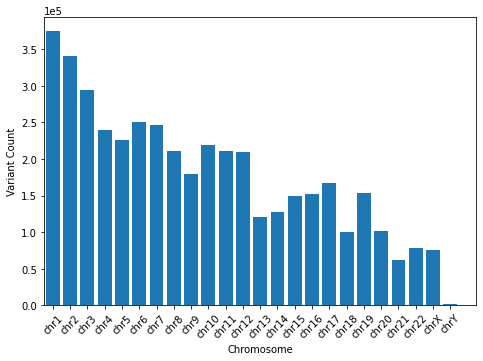

In [230]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1])
ax1.bar(np.arange(24), np.squeeze(np.asarray(x2[0])))
ax1.set_ylabel('Variant Count')
ax1.set_xlabel('Chromosome')
ax1.set_xlim(-0.5,24.5)
ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
plt.xticks(np.arange(24),np.squeeze(np.asarray(x2[1])),rotation=45)


In [200]:
%%R -i x2

x2 %>%
    as_tibble() %>%
    print()

[[374795 340467 293649 240282 226359 251100 246918 210933 180086 218911
  211578 209331 121438 128020 149788 152567 166795 99985 153965 101541
  61843 78862 75799 1304]
 ['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chr10'
  'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17' 'chr18' 'chr19'
  'chr20' 'chr21' 'chr22' 'chrX' 'chrY']]
